<a href="https://colab.research.google.com/github/rosegebhardt/Frequentist-ML/blob/master/logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#----------INCLUDE PACKAGES

import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Dataset Description:
1. Number of times pregnant.
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test.
3. Diastolic blood pressure (mm Hg).
4. Triceps skinfold thickness (mm).
5. 2-Hour serum insulin (mu U/ml).
6. Body mass index (weight in kg/(height in m)^2).
7. Diabetes pedigree function.
8. Age (years).
9. Class variable (0 or 1).

In [ ]:
#----------DATA READING 

data = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv'
dataframe = pd.read_csv(data, sep=',', header=None)

In [ ]:
#----------CLEAN DATA

# Add column to account for intercept 
ones_col = np.ones(len(dataframe))
dataframe.insert(0, "intercept", ones_col, True) 

# Drop rows with missing data
clean_data = dataframe.dropna(axis=0)

# Rename columns
clean_data.columns = ['intercept','times_pregnant','glucose','blood_pres','skin_thickness','insulin','bmi','diabetes_fcn','age','class_value'] 

# Remove rows with invalid data
clean_data = clean_data[clean_data['glucose'] > 0] 
clean_data = clean_data[clean_data['blood_pres'] > 0] 
clean_data = clean_data[clean_data['skin_thickness'] > 0] 
clean_data = clean_data[clean_data['insulin'] > 0] 
clean_data = clean_data[clean_data['bmi'] > 0] 

# Show data information                    
clean_data.describe()

,intercept,times_pregnant,glucose,blood_pres,skin_thickness,insulin,bmi,diabetes_fcn,age,class_value
count,392.0,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,1.0,3.301020,122.627551,70.663265,29.145408,156.056122,33.086224,0.523046,30.864796,0.331633
std,0.0,3.211424,30.860781,12.496092,10.516424,118.841690,7.027659,0.345488,10.200777,0.471401
min,1.0,0.000000,56.000000,24.000000,7.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,1.0,1.000000,99.000000,62.000000,21.000000,76.750000,28.400000,0.269750,23.000000,0.000000
50%,1.0,2.000000,119.000000,70.000000,29.000000,125.500000,33.200000,0.449500,27.000000,0.000000
75%,1.0,5.000000,143.000000,78.000000,37.000000,190.000000,37.100000,0.687000,36.000000,1.000000
max,1.0,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
#----------SEPARATE DATA

# Choose seed
np.random.seed(420)

# Separate training and testing data
train_data, validate_data, test_data = np.split(clean_data.sample(frac=1), [int(.8*len(clean_data)), int(.9*len(clean_data))])

# Separate training inputs and outputs
x_train = train_data.drop(['class_value'], axis=1)  
y_train = train_data['class_value']

# Separate validation inputs and outputs
x_validate = validate_data.drop(['class_value'], axis=1)  
y_validate = validate_data['class_value']

# Separate testing inputs and outputs
x_test = test_data.drop(['class_value'], axis=1)
y_test = test_data['class_value']

# Normalize testing validation and training inputs
x_train = (x_train-x_train.min())/(x_train.max()-x_train.min()) 
x_train.intercept = np.ones(len(x_train))
x_validate = (x_validate-x_validate.min())/(x_validate.max()-x_validate.min()) 
x_validate.intercept = np.ones(len(x_validate))
x_test = (x_test-x_test.min())/(x_test.max()-x_test.min()) 
x_test.intercept = np.ones(len(x_test))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


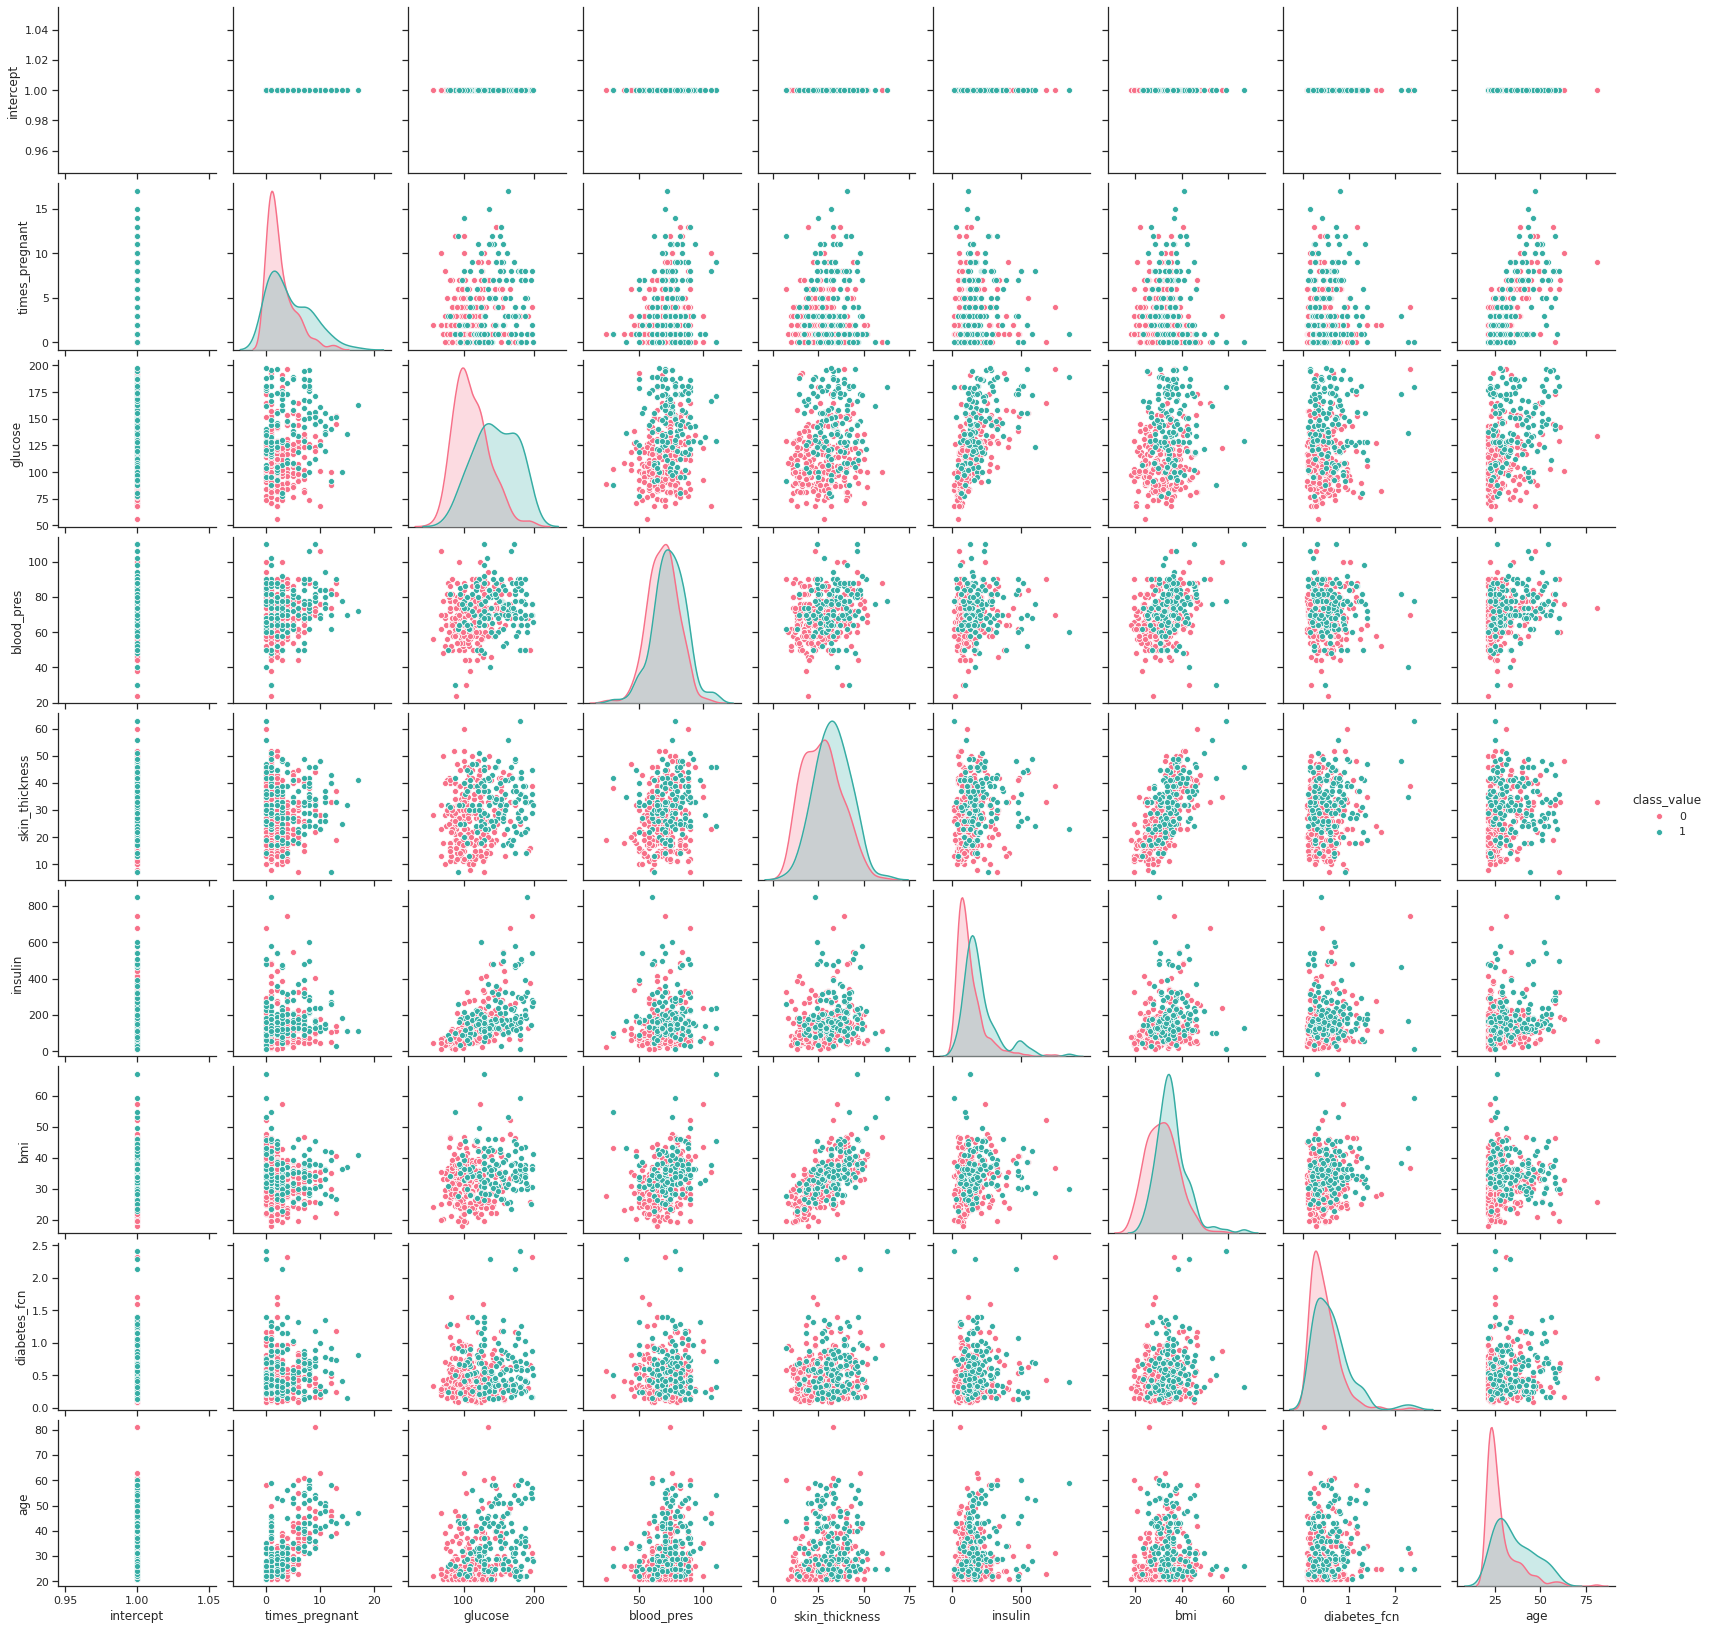

In [ ]:
#----------VISUALIZE DATA

sns.set(style="ticks", color_codes=True)
sns.pairplot(clean_data, hue='class_value', palette="husl") 

In [ ]:
#----------DEFINE FUNCTIONS

# Logistic function
def phi(theta,x):
  out = 1/(1 + np.exp(-1*np.dot(x,theta)))
  return out

# Log-likelihood function
def log_likelihood(theta,train_set,train_truth):
  log_likelihood = 0
  for i in range(train_set.shape[0]):
    addition = train_truth.iloc[i]*np.log(phi(theta,train_set.iloc[i].to_numpy())) + (1 - train_truth.iloc[i])*np.log(1 - phi(theta,train_set.iloc[i].to_numpy()))
    log_likelihood = log_likelihood + addition
  return log_likelihood

# Stochastic gradient descent without regularization
def sgd(gamma,train_set,train_truth):
  theta_old = np.zeros((train_set.shape[1],1))
  likelihood = np.zeros((2000,1))
  for i in range(2000):
    x_t = train_set.sample()
    y_t = train_truth[x_t.index]
    x_t = x_t.to_numpy()
    y_t = y_t.to_numpy()
    theta_new = theta_old + np.transpose(gamma*(y_t - phi(theta_old,x_t))*x_t)
    likelihood[i] = log_likelihood(theta_new,train_set,train_truth)
    theta_old = theta_new
  return theta_old, likelihood

# Stochastic gradient descent with L2 regularization
  # Does not compute log likelihood to save time
def sgd_l2_noll(gamma,lam,train_set,train_truth):
  theta_old = np.zeros((train_set.shape[1],1))
  for i in range(1000):
    x_t = train_set.sample()
    y_t = train_truth[x_t.index]
    x_t = x_t.to_numpy()
    y_t = y_t.to_numpy()
    theta_new = theta_old + np.transpose(gamma*(y_t - phi(theta_old,x_t))*x_t) - 2*lam*theta_old
    theta_old = theta_new
  return theta_old

  # Computes and stores log likelihood
def sgd_l2(gamma,lam,train_set,train_truth):
  theta_old = np.zeros((train_set.shape[1],1))
  likelihood = np.zeros((2000,1))
  for i in range(2000):
    x_t = train_set.sample()
    y_t = train_truth[x_t.index]
    x_t = x_t.to_numpy()
    y_t = y_t.to_numpy()
    theta_new = theta_old + np.transpose(gamma*(y_t - phi(theta_old,x_t))*x_t) - 2*lam*theta_old
    likelihood[i] = log_likelihood(theta_new,train_set,train_truth)
    theta_old = theta_new
  return theta_old,likelihood

# Predictions (based on SGD results)
def predict(test_set,theta):
  predictions = np.zeros((test_set.shape[0],1))
  for i in range(test_set.shape[0]):
    temp1 = test_set.iloc[i].to_numpy()
    temp2 = np.reshape(temp1, (1,9))
    if phi(theta,temp2) < 0.5:
      predictions[i] = 0
    else:
      predictions[i] = 1
  return predictions

# Percent correct (based on SGD results and predictions)
def accuracy(test_set,ground_truth,theta):
  guesses = predict(test_set,theta)
  truth = np.reshape(ground_truth.to_numpy(),(ground_truth.shape[0],1))
  acc = sum(guesses == truth)/ground_truth.shape[0]
  return acc[0]

In [ ]:
#----------FIND BEST HYPERPARAMETER

# Create array of possible lambdas
lam_vect = np.linspace(0,0.1,num=50)

# Initialize accuracy values
vals = np.zeros(lam_vect.shape)

# Find the accuracy for each lambda
for index,val in enumerate(lam_vect):
    vals[index] = accuracy(x_validate,y_validate,sgd_l2_noll(0.025,val,x_train,y_train))

# Find lambda that maximizes the accuracy
maxpos = np.where(vals == vals.max())
best_lam = lam_vect[maxpos]

In [ ]:
#----------RESULTS OF CLASSIFICATION

# No regularization
sgd_results = sgd(0.025,x_train,y_train)
predictions = predict(x_test, sgd_results[0])
accuracy = accuracy(x_test,y_test,sgd_results[0])
percent_correct = accuracy*100
print("The accuracy on the test set is using unregularized stochastic gradient descent", percent_correct, "%.")

# L2 regularization
sgd_l2_results = sgd_l2(0.025,best_lam[-1],x_train,y_train)
predictions_l2 = predict(x_test, sgd_l2_results[0])
accuracy_l2 = accuracy(x_test,y_test,sgd_l2_results[0])
percent_correct_l2 = accuracy_l2*100
print("The accuracy on the test set is using regularized stochastic gradient descent is", percent_correct, "%.")

The accuracy on the test set is using unregularized stochastic gradient descent 82.5 %.
The accuracy on the test set is using regularized stochastic gradient descent is 82.5 %.


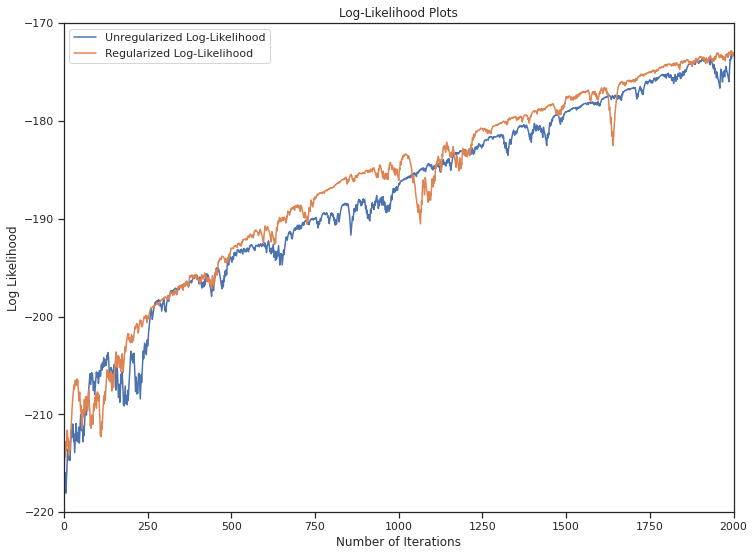

In [ ]:
#----------LIKELIHOOD PLOT

# Likelihood plot
fig = plt.figure(figsize=(12,9))
plt.plot(sgd_results[1])
plt.plot(sgd_l2_results[1])
plt.title('Log-Likelihood Plots')
plt.ylabel('Log Likelihood')
plt.xlabel('Number of Iterations')
plt.xlim([0,2000])
plt.ylim([-220,-170])
plt.legend(['Unregularized Log-Likelihood','Regularized Log-Likelihood'])
plt.show()


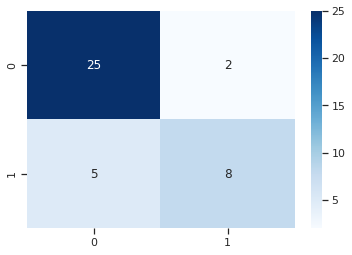

In [ ]:
sns.heatmap(tf.math.confusion_matrix(y_test.to_numpy(), predictions), cmap="Blues", annot=True)

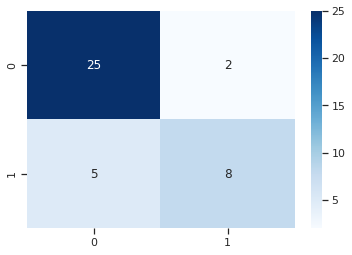

In [ ]:
sns.heatmap(tf.math.confusion_matrix(y_test.to_numpy(), predictions_l2), cmap="Blues", annot=True)